In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.time import Time
import os


from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker
output_notebook()


from gatspy.periodic import LombScargleFast, LombScargle


import matplotlib.pyplot as plt
%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

Loading BokehJS ...

In [2]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



def getvegamaganddates(data,columnfile,name):
    vegamagindex = np.arange(28,6568,13)
    
    
    vegamaglist = np.array([float(data[i]) for i in vegamagindex])
    vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])
    
    columns = []
    with open(columnfile) as filecol:
        for line in filecol:
            columns.append(line)
    listanames = []
    dates = []
    times =[]
    nameobject = []
    namel=[]

    for i in vegamagindex:
        initname = columns[i].find('Try/u')
        namefits = columns[i][initname:initname+23]
        listanames.append(namefits)
        fit = fits.open(namefits+'.fits')
        dates.append(fit[0].header['DATE-OBS'])
        times.append(fit[0].header['TIME-OBS'])
        namel.append(name)
    datesobs = [['{}T{}'.format(i,j)] for i,j in zip(dates,times)]

    d = np.array(datesobs)
    t = Time(d)
    namel = np.array(namel)
       
    return vegamaglist, vegamaglisterrors,t, d, namel


def createdatadiccomplete(data,columnfile):
    vegamag,vegamagerrros, timelist, observationname = getvegamaganddates(data,columnfile)
    datadic = {'time':timelist.datetime64,
               'VEGAMAG':vegamag,
               'obnames':observationname,
                'errorsmag':vegamagerrros}
    return datadic
            
def createdatadicclean(datafile,index,columnfile,name='name'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)

    datadic = {'time':timelist.datetime64[goodvegamagindex],
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic


def createdatadicclean(datafile,index,columnfile,name='name',timeformat='datetime64'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)
    if timeformat == 'datetime64':
        timelist2 = timelist.datetime64[goodvegamagindex]
    elif timeformat == 'mjd':
        timelist2 = timelist.mjd[goodvegamagindex]

    datadic = {'time':timelist2,
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic

In [3]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'

In [4]:
datagood230 = createdatadicclean(outputfile,230,columnfile,name='230')
datagood737 =  createdatadicclean(outputfile,737,columnfile,name='737')


sed '231q;d'  outdir/out.photo
['512.14', '128.26']
sed '738q;d'  outdir/out.photo
['515.39', '125.65']


# Plot

In [5]:

source = ColumnDataSource(data=datagood230)
source2 = ColumnDataSource(data=datagood737)


p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
          x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@obnames)')
        ]
    )

        
p.add_tools(hover2)



# add a circle renderer with a size, color, and alpha
p.circle('time','VEGAMAG', source=source, color='red', name='name',legend='name')
p.add_layout(
    Whisker(source=source, base="time", upper="upper", lower="lower")
)


#Add another
p.circle('time','VEGAMAG', source=source2, color='blue',legend='name')
p.add_layout(
    Whisker(source=source2, base="time", upper="upper", lower="lower")
)






show(p)

In [6]:
datagood737mjd =  createdatadicclean(outputfile,737,columnfile,name='737',timeformat='mjd')

sed '738q;d'  outdir/out.photo
['515.39', '125.65']


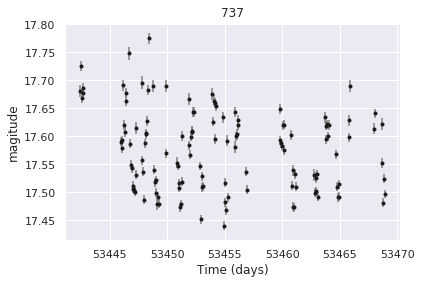

In [129]:
fig, ax = plt.subplots()

t737, mag737, dmag737 = datagood737mjd['time'], datagood737mjd['VEGAMAG'],datagood737mjd['errorsmag']

ax.errorbar(t737, mag737, dmag737,  fmt='.k', ecolor='gray')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title=datagood737mjd['name'][0])
#ax.invert_yaxis();
plt.show()

# Scipy

[0.99579895]


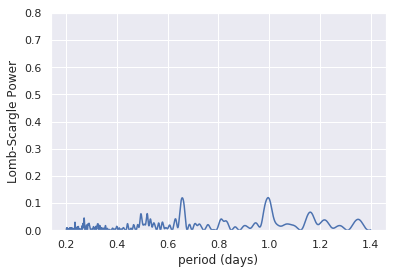

In [146]:


from scipy.signal import lombscargle

# Choose a period grid
periods = np.linspace(0.2, 1.4, 4000)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
# note pre-centering of y values!
power = lombscargle(t737.flatten(), mag737 - mag737.mean(), ang_freqs)

# normalize the power
N = len(t)
power *= 2 / (N * mag.std() ** 2)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');




In [147]:

indexmax = np.where(power == power.max())
periodmax = periods[indexmax]
#print(periodmax)

# Compute phases of the obsevations
phase = (t737.flatten() / period) % 1

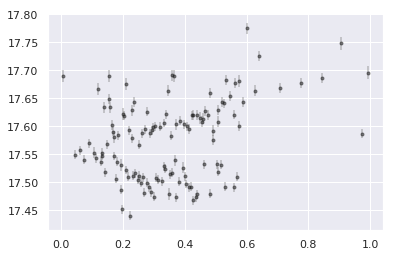

In [149]:
# Plot the phased data & model
fig, ax = plt.subplots()


ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
plt.show()

# Gatspy

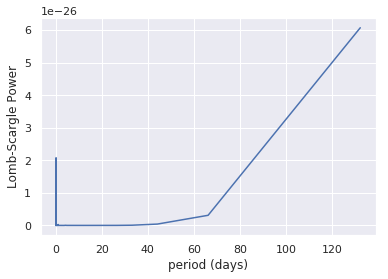

In [130]:
model = LombScargleFast().fit(t737, mag737, dmag737)
periods, power = model.periodogram_auto(nyquist_factor=200)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');
plt.show()

In [131]:
# set range and find period
model.optimizer.period_range=(0.2, 1.4)
period = model.best_period
print("period = {0}".format(period))



Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0475
 - User-specified period range:  0.2 to 1.4
 - Computing periods at 569 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 0.9863764050968513


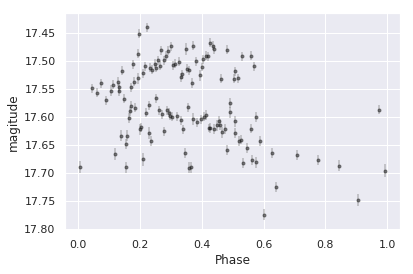

In [150]:
# Compute phases of the obsevations
phase = (t / period) % 1


# Plot the phased data & model
fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();